# Import Dependencies

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential 
import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from math import dist
from turtle import home
import numpy as np
from geopy.distance import geodesic
from haversine import haversine



def haversine_dist(x1,x2,y1,y2):
   return haversine((x1, x2) , (y1, y2), unit='km')

# Data Processing 



def extract_features_from_longitude_latitude(df, home_longitude, home_latitude):
    home_coords = (home_latitude, home_longitude)

    df['distance_from_home'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],home_latitude,home_longitude)

    df['heading_to_home'] = np.arctan2(df['mean_latitude'] - home_latitude, df['mean_longitude'] - home_longitude)
    df['heading_to_home_sin'] = np.sin(df['heading_to_home'])
    df['heading_to_home_cos'] = np.cos(df['heading_to_home'])
    # resample by 10m mean
    df['time_stamp'] = df.index
    # calculate the speed of device
    df['time_diff'] = df['time_stamp'].diff().dt.total_seconds() / 3600  # Convert seconds to hours
    df['distance'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],df['mean_latitude'].shift(1),df['mean_longitude'].shift(1)) #calculate haversine distance
    # df['hours'] = (df['time_stamp'].astype(int) / 10**9) / 60*60 # convert to seconds
    # df['time_taken'] = df['hours'] - df['hours'].shift(1) # calculate time difference

    df['speed'] = df['distance']/df['time_diff'] # cal speed
    df.loc[df['speed'] > 200, 'speed'] = 0
    df['speed_towards_home'] = df['speed'] * df['heading_to_home_cos']
    return df

# df = df.resample('10T').mean()


In [3]:
from influxdb import DataFrameClient
import pandas as pd
db_name_zuka = 'smart_home_zukalovi'
dataframe_client_zuka = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )

left_time_interval = pd.to_datetime('2023-10-01 00:00:00')
right_time_interval = pd.to_datetime('2024-3-16 15:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '10s'
tmp_output_water_entity_id_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id_zuka = 'esphome_web_c771e8_tmp3'
relay_entity_id_zuka = 'shelly1pm_84cca8b07eae'
device_tracker_entity_zuka = 'klara_z_iphone'


In [4]:
dataframe_client_form = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi',
        )
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'

In [5]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ


def get_queries(db_name, left_time_interval, right_time_interval, group_by_time_interval, tmp_output_water_entity_id, tmp_output_water_entity_id_2, tmp_boiler_case_entity_id, relay_entity_id, device_tracker_entity):

    return {
        "water_flow": {
            "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "L/min",
        },
        "water_temperature": {
            "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "°C",
        },
        "temperature": {
            "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "humidity": {
            "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "wind_speed": {
            "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "presence": {
            "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "state",
        },
        "boiler_water_temperature": {
            "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "°C",
        },
        "boiler_relay_status": {
            "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "device_longitude": {
            "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(linear)',
            "measurement": "state",
        },
        "device_latitude": {
            "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(linear)',
            "measurement": "state",
        },
        
    } 

In [6]:
df_all_list = []

for key, value in get_queries(db_name = db_name_form, left_time_interval = left_time_interval, right_time_interval = right_time_interval, group_by_time_interval = group_by_time_interval, tmp_output_water_entity_id = tmp_output_water_entity_id_form, tmp_output_water_entity_id_2 = tmp_output_water_entity_id_2_form, tmp_boiler_case_entity_id = tmp_boiler_case_entity_id_form, relay_entity_id = relay_entity_id_form, device_tracker_entity = device_tracker_entity_form).items():
    print("Querying: ", key, value["sql_query"])
    # get data from influxdb
    result = dataframe_client_form.query(value["sql_query"])[
        value["measurement"]
    ]

    df = pd.DataFrame(result)
    
    df_all_list.append(df)

df_concat_form = pd.concat(df_all_list, axis=1)
# save as pkl
with open('df_form_mult_16032024.pkl', 'wb') as f:
    df_concat_form.to_pickle(f)

Querying:  water_flow SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_formankovi"."autogen"."L/min" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' GROUP BY time(10s) FILL(0)
Querying:  water_temperature SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_formankovi"."autogen"."°C" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' AND ("entity_id"='esphome_boiler_temps_ntc_temperature_b_constant' OR "entity_id"='esphome_web_b7a7f1_ntc_temperature_b_constant') GROUP BY time(10s) FILL(0)
Querying:  temperature SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_formankovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(10s) FILL(null)
Querying:  humidity SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_formankovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' A

In [7]:
df_all_list = []
    # iterate over key an value in data
for key, value in get_queries(db_name=db_name_zuka, left_time_interval=left_time_interval, right_time_interval=right_time_interval, group_by_time_interval='10s', tmp_output_water_entity_id=tmp_output_water_entity_id_2_zuka, tmp_output_water_entity_id_2=tmp_output_water_entity_id_zuka, tmp_boiler_case_entity_id=tmp_boiler_case_entity_id_zuka, relay_entity_id=relay_entity_id_zuka, device_tracker_entity=device_tracker_entity_zuka).items():
    print("Querying: ", key, value["sql_query"])
    # get data from influxdb
    result = dataframe_client_zuka.query(value["sql_query"])[
        value["measurement"]
    ]

    df = pd.DataFrame(result)
    
    df_all_list.append(df)

df_concat_zuka = pd.concat(df_all_list, axis=1)
# save as pkl
with open('df_zuka_mult_16032024.pkl', 'wb') as f:
    df_concat_zuka.to_pickle(f)

Querying:  water_flow SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' GROUP BY time(10s) FILL(0)
Querying:  water_temperature SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' AND ("entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2' OR "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant') GROUP BY time(10s) FILL(0)
Querying:  temperature SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time < '2024-03-16T15:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(10s) FILL(null)
Querying:  humidity SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-10-01T00:00:00Z' AND time 

In [8]:
#load df form pkl
import pickle 
with open('df_form_mult_16032024.pkl', 'rb') as f:
    df_concat_form = pickle.load(f)
    df_concat_form = df_concat_form.dropna(subset=['water_temperature_mean'])

    
    


In [9]:
with open('df_zuka_mult_16032024.pkl', 'rb') as f:
    df_concat_zuka = pickle.load(f)
    df_concat_zuka = df_concat_zuka.dropna(subset=['water_temperature_mean'])
    


In [10]:
df_concat_form['household_members'] = 2
df_concat_zuka['household_members'] = 6
df_concat_form['boiler_size'] = 80
df_concat_zuka['boiler_size'] = 120

In [11]:
#49.412897925874184, 16.514843458109933
zuka_home_latitude = 49.412897925874184
zuka_home_longitude = 16.514843458109933
df_copy_zuka = df_concat_zuka.copy()
df_extracted_zuka = extract_features_from_longitude_latitude(df_copy_zuka, home_longitude=zuka_home_longitude, home_latitude=zuka_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_zuka.loc[df_extracted_zuka['speed'] > 200, 'speed'] = 0

In [12]:
# 49.39534649920643, 16.527887919743097
form_home_latitude = 49.39534649920643
form_home_longitude = 16.527887919743097

df_copy_form = df_concat_form.copy()
df_extracted_form = extract_features_from_longitude_latitude(df_copy_form, home_longitude=form_home_longitude, home_latitude=form_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_form.loc[df_extracted_form['speed'] > 200, 'speed'] = 0

<AxesSubplot:>

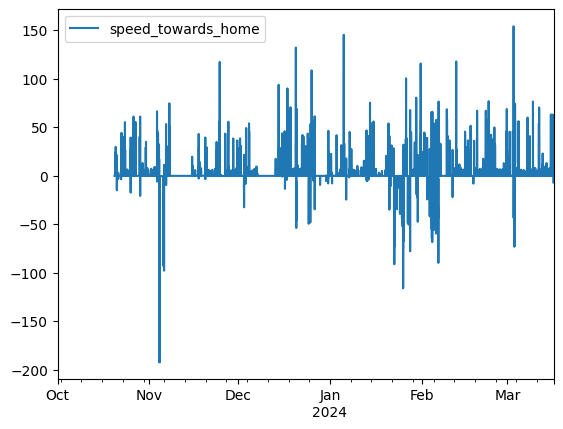

In [13]:
df_extracted_zuka.plot(y='speed_towards_home')

In [14]:
from data_handler_test import DataHandlerTest

Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler_test.py


In [15]:
left_time_interval = pd.to_datetime("2023-10-01 00:00:00")
right_time_interval = pd.to_datetime("2024-3-16 15:00:00")
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = "10s"
tmp_output_water_entity_id_zuka = "esphome_web_c771e8_ntc_temperature_b_constant"
tmp_output_water_entity_id_2_zuka = "esphome_web_c771e8_ntc_temperature_b_constant_2"
tmp_boiler_case_entity_id_zuka = "esphome_web_c771e8_tmp3"
relay_entity_id_zuka = "shelly1pm_84cca8b07eae"
relay_power_entity_id_zuka = "shelly1pm_84cca8b07eae_power"
device_tracker_entity_zuka = "klara_z_iphone"

dataHandlerTest = DataHandlerTest(
    "localhost", "smart_home_zukalovi", "root", "root", relay_entity_id_zuka, relay_power_entity_id_zuka, tmp_boiler_case_entity_id_zuka, tmp_output_water_entity_id_zuka, tmp_output_water_entity_id_2_zuka, device_tracker_entity_zuka
)

In [16]:
data_processed_form = dataHandlerTest.process_kWh_water_consumption(df_extracted_form)
data_processed_zuka = dataHandlerTest.process_kWh_water_consumption(df_extracted_zuka)

In [17]:
data_processed_form_ml = dataHandlerTest.transform_data_for_ml(data_processed_form)
data_processed_zuka_ml = dataHandlerTest.transform_data_for_ml(data_processed_zuka)

In [18]:
ml_data_form = data_processed_form_ml[0]
ml_data_zuka = data_processed_zuka_ml[0]

In [19]:
ml_data_form

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,0.000000e+00,1.000000,0.000000e+00,1.0
1,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,0.000000e+00,1.000000,5.665539e-16,-1.0
2,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,2.588190e-01,0.965926,0.000000e+00,1.0
3,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,2.588190e-01,0.965926,5.665539e-16,-1.0
4,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,5.000000e-01,0.866025,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8041,0.030595,2.060024,0.003878,3.833333,-0.816908,0.576767,-0.974928,-0.222521,1.224647e-16,-1.000000,5.665539e-16,-1.0
8042,0.027489,3.611541,28.658534,0.500000,-0.576063,0.797724,-0.974928,-0.222521,-2.588190e-01,-0.965926,0.000000e+00,1.0
8043,0.027489,3.611541,28.658534,0.000000,-0.576063,0.797724,-0.974928,-0.222521,-2.588190e-01,-0.965926,5.665539e-16,-1.0
8044,0.026042,3.611541,28.658534,0.000000,-0.576063,0.797724,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.000000e+00,1.0


In [20]:
import pandas as pd
data_all_ml = pd.concat([ml_data_form, ml_data_zuka])

In [21]:
data_all_ml

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,0.000000e+00,1.000000,0.000000e+00,1.0
1,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,0.000000e+00,1.000000,5.665539e-16,-1.0
2,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,2.588190e-01,0.965926,0.000000e+00,1.0
3,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,2.588190e-01,0.965926,5.665539e-16,-1.0
4,0.026042,NaN,NaN,0.000000,NaN,NaN,-0.781831,0.623490,5.000000e-01,0.866025,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8041,0.032220,0.339105,8.25685,6.166667,0.163139,0.981056,-0.974928,-0.222521,1.224647e-16,-1.000000,5.665539e-16,-1.0
8042,0.032220,0.339105,8.25685,3.333333,0.163139,0.981056,-0.974928,-0.222521,-2.588190e-01,-0.965926,0.000000e+00,1.0
8043,0.026040,0.339105,8.25685,0.000000,0.163139,0.981056,-0.974928,-0.222521,-2.588190e-01,-0.965926,5.665539e-16,-1.0
8044,0.026042,0.339105,8.25685,0.000000,0.163139,0.981056,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.000000e+00,1.0


<AxesSubplot:>

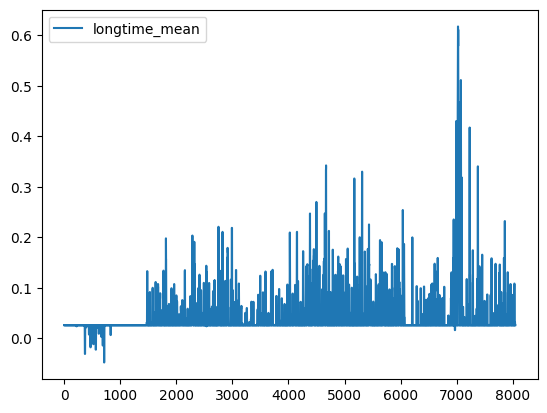

In [22]:
data_all_ml.plot(y='longtime_mean')

In [23]:
df = ml_data_zuka.reset_index(drop=True)
df = pd.concat([df.iloc[350:900], df.iloc[2100:3200], df.iloc[4200:]])
df = df.reset_index(drop=True).dropna()
df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]



## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

In [24]:
from sklearn.preprocessing import RobustScaler

df_train_norm = df_train.copy()
df_test_norm = df_test.copy()

scaler = RobustScaler()

# df_train_norm.loc[:,predicted_column:] = scaler.fit_transform(df_train.loc[:,predicted_column:])
# df_test_norm.loc[:,predicted_column:] = scaler.transform(df_test.loc[:,predicted_column:])
df_train_norm[df_train.columns] = scaler.fit_transform(df_train)
df_test_norm[df_train.columns] = scaler.transform(df_test)




df_train_norm.head()


,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
550,-1.526021e-15,-0.349021,-0.088289,-3.294118,-0.057155,-0.028528,0.0,0.801938,-0.707107,-1.731912e-16,0.000000e+00,0.0
551,-1.526021e-15,-0.350389,-0.088900,-3.294118,-0.057391,-0.032010,0.0,0.801938,-0.707107,-1.731912e-16,5.665539e-16,-1.0
552,-1.526021e-15,-0.351757,-0.089514,-3.294118,-0.057628,-0.035509,0.0,0.801938,-0.683013,1.830127e-01,0.000000e+00,0.0
553,-1.526021e-15,-0.353125,-0.090132,-3.294118,-0.057865,-0.039027,0.0,0.801938,-0.683013,1.830127e-01,5.665539e-16,-1.0
554,-1.526021e-15,-0.354492,-0.090752,-3.294118,-0.058101,-0.042562,0.0,0.801938,-0.612372,3.535534e-01,0.000000e+00,0.0


## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [25]:
def mul_generator(dataframe, target_names, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    data = dataframe.values
    data = data.astype(np.float32)
    
    # Get the column indices for the target names
    target_indices = [dataframe.columns.get_loc(target_name) for target_name in target_names]
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        
        # Modify targets array to accommodate multiple target columns
        targets = np.zeros((len(rows), len(target_indices)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            
            # Assign values for each target column
            for k, target_indx in enumerate(target_indices):
                targets[j][k] = data[rows[j] + delay][target_indx]
                
        yield samples, targets


## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [26]:
# use previous 450 samples to predict next target ('pollution') samples

predicted_columns = [
    "longtime_mean",
    "distance_from_home",
    "speed_towards_home",
    "count",
    "heading_to_home_sin",
    "heading_to_home_cos",
]

lookback = 10
batch_size = 16
delay = 1
train_gen = mul_generator(
    dataframe=df_train_norm,
    target_names=predicted_columns,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=int(df_train.shape[0] * 0.8),
    step=1,
    shuffle=True,
    batch_size=batch_size,
)

valid_gen = mul_generator(
    dataframe=df_train_norm,
    target_names=predicted_columns,
    lookback=lookback,
    delay=delay,
    min_index=int(df_train.shape[0] * 0.8),
    max_index=None,
    step=1,
    shuffle=False,
    batch_size=batch_size,
)

In [27]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = int((df_train_norm.shape[0]*0.1 - lookback) // batch_size)
print('validation_steps = ', val_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
train_steps = int((df_train_norm.shape[0]*0.9 - lookback) // batch_size)
print('train_steps = ', train_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
test_steps = int((df_test_norm.shape[0] - lookback) // batch_size)
print('test_steps = ', test_steps)
#7,80,21

validation_steps =  20
train_steps =  191
test_steps =  95


In [190]:
# def r2_keras(y_true, y_pred):
#     """Coefficient of Determination 
#     """
#     SS_res =  K.sum(K.square( y_true - y_pred ))
#     SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r2_keras(y_true, y_pred):
    """Coefficient of Determination for multiple outputs"""
    SS_res = K.sum(K.square(y_true - y_pred), axis=0)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis=0)), axis=0)
    return K.mean(1 - SS_res / (SS_tot + K.epsilon()))

## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

In [191]:
from keras.layers import LSTM
from keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf



model = Sequential()
model.add(tf.keras.Input(shape=(None, df_train.shape[1])))
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50, return_sequences=False, activation='relu'))
model.add(Dense(len(predicted_columns)))




## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

In [192]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

callbacks = [EarlyStopping(monitor='loss', min_delta = 0, patience=10, verbose=2, mode='auto', restore_best_weights=True),
             ModelCheckpoint(filepath='lstm_model_mul_var.keras', monitor='val_loss', save_best_only=True)]

model.compile(loss='mae', optimizer='adam', metrics=[r2_keras])
# history = model.fit(train_gen, epochs=50, batch_size=72, validation_data=valid_gen, verbose=2, shuffle=False, use_multiprocessing=True)

history = model.fit(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=70,
                              shuffle=False,
                              validation_data=valid_gen,
                              validation_steps=val_steps,
                              callbacks = callbacks)

Epoch 1/70


191/191 [==============================] - 2s 4ms/step - loss: 2.0316 - r2_keras: -243.9232 - val_loss: 1.6997 - val_r2_keras: -2912078.5000
Epoch 2/70
191/191 [==============================] - 1s 3ms/step - loss: 1.8654 - r2_keras: 0.2219 - val_loss: 5.9907 - val_r2_keras: -15305066.0000
Epoch 3/70
191/191 [==============================] - 1s 3ms/step - loss: 1.8297 - r2_keras: -178.0376 - val_loss: 1.9431 - val_r2_keras: -505776.7500
Epoch 4/70
191/191 [==============================] - 1s 3ms/step - loss: 1.8838 - r2_keras: 0.2011 - val_loss: 5.7078 - val_r2_keras: -18784798.0000
Epoch 5/70
191/191 [==============================] - 1s 3ms/step - loss: 1.6299 - r2_keras: 0.3712 - val_loss: 2.2383 - val_r2_keras: -654825.1250
Epoch 6/70
191/191 [==============================] - 1s 3ms/step - loss: 1.7476 - r2_keras: 0.3602 - val_loss: 5.5868 - val_r2_keras: -5362478.5000
Epoch 7/70
191/191 [==============================] - 1s 4ms/step - loss: 1.7676 - r2_keras: 0.2309 - val_loss:

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [193]:
model = load_model('lstm_model_mul_var.keras', custom_objects={'r2_keras': r2_keras})

In [194]:
df_test_norm.shape

(1540, 12)

In [195]:
# append a value to all rows in longtimemean column zeroes

test_gen = mul_generator(dataframe = df_test_norm, 
                      target_names = predicted_columns, 
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])
(X, y_truth) = next(test_gen)
y_pred = model.predict(X)


48/48 [==============================] - 0s 1ms/step


In [196]:
from datetime import timedelta, datetime
import pandas as pd


In [197]:



def get_forecast_next_steps(left_time_interval, right_time_interval):
    # Define the indices for the different predictions and truths
    LONGTIME_MEAN_INDEX = 0
    DISTANCE_FROM_HOME_INDEX = 1
    SPEED_INDEX = 2
    num_targets = len(predicted_columns)
    len_columns = len(df_test.columns)


    forecast_future = pd.DataFrame()

    df_all = dataHandlerTest.get_data_for_prediction(
        left_time_interval=left_time_interval,
        right_time_interval=right_time_interval,
        predicted_columns=predicted_columns,
    )
    df_all = df_all.dropna()
    df_all = df_all.reset_index(drop=True)
    forecast_future = pd.DataFrame()

    current_forecast_begin_date = right_time_interval + timedelta(hours=0.5)

    # prediction for next 6 hours
    for i in range(0, 12):
        new_row_df = pd.DataFrame(
            columns=df_all.columns,
            data=[
                [
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    np.sin(2 * np.pi * current_forecast_begin_date.weekday() / 7),
                    np.cos(2 * np.pi * current_forecast_begin_date.weekday() / 7),
                    np.sin(2 * np.pi * current_forecast_begin_date.hour / 24),
                    np.cos(2 * np.pi * current_forecast_begin_date.hour / 24),
                    np.sin(2 * np.pi * current_forecast_begin_date.minute / 60),
                    np.cos(2 * np.pi * current_forecast_begin_date.minute / 60),
                ]
            ],
        )

        df_all = pd.concat([df_all, new_row_df], ignore_index=True)
        df_all = df_all.reset_index(drop=True)

        df_predict_norm = df_all.copy()

        df_predict_norm[df_all.columns] = scaler.transform(df_all)
        # create predict df with values
        predict_gen = mul_generator(
            dataframe=df_predict_norm,
            target_names=predicted_columns,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=1,
            shuffle=False,
            batch_size=df_predict_norm.shape[0],
        )

        (X, y_truth) = next(predict_gen)
        y_pred = model.predict(X, verbose=0)
        # np.expand_dims(y_truth,axis=1).shape
        y_pred_inv = np.concatenate(
            (y_pred, np.zeros((y_pred.shape[0], len_columns-num_targets))), axis=1
        )
        y_pred_inv = scaler.inverse_transform(y_pred_inv)
        # get last predicted value
        y_pred_inv = y_pred_inv[-1, :]

        # append y_pred_inv to df_all
        df_all.iloc[-1][:num_targets] = y_pred_inv[:num_targets]

        # drop first row
        df_all = df_all[1:]

        forecast_future = pd.concat(
            [
                forecast_future,
                df_all.iloc[-1][:num_targets],
            ],
            axis=0,
        )
        forecast_future = forecast_future.reset_index(drop=True)

        current_forecast_begin_date += timedelta(hours=0.5)
        

    return forecast_future, df_all

# last 48 values

In [199]:

one_week_prediction = []
number_of_30_minutes = 14*24*2
end_train = datetime(2024,1,1, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=48)


for i in range(0, number_of_30_minutes):
    next_steps, _ = get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(minutes=30)
    end_of_data_loader_for_forecast += timedelta(minutes=30)

['longtime_mean', 'distance_from_home', 'speed_towards_home', 'count', 'heading_to_home_sin', 'heading_to_home_cos']
[[[ 1.92572308e+01 -8.03861260e-01  1.52336456e+02 ... -5.00000000e-01
    0.00000000e+00  0.00000000e+00]
  [ 1.19732199e+01 -9.35664237e-01  3.78615646e+01 ... -5.00000000e-01
    5.66553869e-16 -1.00000000e+00]
  [ 1.20409393e+01 -9.50970113e-01 -1.88132063e-01 ... -6.12372458e-01
    0.00000000e+00  0.00000000e+00]
  ...
  [ 5.10937750e-01 -9.51412618e-01 -1.87844619e-01 ... -7.07106769e-01
    5.66553869e-16 -1.00000000e+00]
  [ 2.86998689e-01 -9.51474249e-01 -1.89425260e-01 ... -6.83012724e-01
    0.00000000e+00  0.00000000e+00]
  [ 1.51139145e+01 -9.51510310e-01 -1.94331244e-01 ... -6.83012724e-01
    5.66553869e-16 -1.00000000e+00]]

 [[ 1.19732199e+01 -9.35664237e-01  3.78615646e+01 ... -5.00000000e-01
    5.66553869e-16 -1.00000000e+00]
  [ 1.20409393e+01 -9.50970113e-01 -1.88132063e-01 ... -6.12372458e-01
    0.00000000e+00  0.00000000e+00]
  [ 1.20168295e+01 

In [ ]:
df_truth = dataHandlerTest.get_data_for_prediction(left_time_interval=end_train+timedelta(hours=48), right_time_interval=end_train+timedelta(hours=48)+timedelta(minutes=30*number_of_30_minutes))

In [ ]:
df_truth

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0.026042,NaN,NaN,53.000000,NaN,NaN,0.974928,-0.222521,0.000000,1.000000,0.000000e+00,1.0
1,0.026042,NaN,NaN,50.166667,NaN,NaN,0.974928,-0.222521,0.000000,1.000000,5.665539e-16,-1.0
2,0.026042,NaN,NaN,56.333333,NaN,NaN,0.974928,-0.222521,0.258819,0.965926,0.000000e+00,1.0
3,0.026042,NaN,NaN,55.666667,NaN,NaN,0.974928,-0.222521,0.258819,0.965926,5.665539e-16,-1.0
4,0.026042,NaN,NaN,71.833333,NaN,NaN,0.974928,-0.222521,0.500000,0.866025,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075,0.781831,0.623490,-0.707107,0.707107,5.665539e-16,-1.0
668,0.026042,25.951927,3.209147,52.833333,-0.943067,0.325075,0.781831,0.623490,-0.500000,0.866025,0.000000e+00,1.0
669,0.026042,25.951927,3.209147,65.166667,-0.943067,0.325075,0.781831,0.623490,-0.500000,0.866025,5.665539e-16,-1.0
670,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075,0.781831,0.623490,-0.258819,0.965926,0.000000e+00,1.0


In [ ]:
list_df = []
for df in one_week_prediction:
    df_reshaped = (pd.DataFrame(np.reshape(df.values, (-1, 6)))).T
    df_reshaped['prediction'] = [i for i in predicted_columns]

    # transpose 
    list_df.append(df_reshaped)
    
    


         0         1         2          3          4         5         6   \
0  0.018752  0.016412  0.015072   0.060741   0.046837  0.032160  0.031633   
1 -4.901093  6.487477  1.394721  28.237615  26.359387 -3.591338  0.001343   
2  0.386746  0.491880  0.520820   0.206976  -0.038535 -0.281048 -0.155552   
3  5.526571  4.615403  4.968277   5.405154   5.353142  3.692251  4.724721   
4 -1.181090 -1.340870 -0.880941   0.481055  -0.259246  1.550800  1.223652   
5  0.478057  0.336305  0.361593   0.870459  -0.280117 -0.681967 -0.329620   

         7          8          9         10        11  
0  0.027336   0.023895   0.025875  0.024544  0.027013  
1  5.823870  10.596025  11.743793  9.985803  6.463384  
2  0.005865   0.006144   0.004162  0.026909  0.056635  
3  4.590955   4.411247   4.802738  4.084106  3.821805  
4  0.605670  -0.147131  -0.433719 -0.381552 -0.385046  
5  0.035074   0.077162  -0.047631 -0.137742 -0.025879  
         0         1         2          3          4         5      

In [ ]:
merged_df = pd.concat(list_df, ignore_index=True)


In [ ]:
merged_df['DataFrame_Order'] = [i for i in range(len(list_df)) for _ in range(6)]


In [ ]:
longtime_mean = merged_df[merged_df['prediction'] == 'longtime_mean']
distance_from_home = merged_df[merged_df['prediction'] == 'distance_from_home']
speed_towards_home = merged_df[merged_df['prediction'] == 'speed_towards_home']
count = merged_df[merged_df['prediction'] == 'count']
heading_to_home_sin = merged_df[merged_df['prediction'] == 'heading_to_home_sin']
heading_to_home_cos = merged_df[merged_df['prediction'] == 'heading_to_home_cos']




In [ ]:
merged_df

,0,1,2,3,4,5,6,7,8,9,10,11,prediction,DataFrame_Order
0,0.018752,0.016412,0.015072,0.060741,0.046837,0.032160,0.031633,0.027336,0.023895,0.025875,0.024544,0.027013,longtime_mean,0
1,-4.901093,6.487477,1.394721,28.237615,26.359387,-3.591338,0.001343,5.823870,10.596025,11.743793,9.985803,6.463384,distance_from_home,0
2,0.386746,0.491880,0.520820,0.206976,-0.038535,-0.281048,-0.155552,0.005865,0.006144,0.004162,0.026909,0.056635,speed_towards_home,0
3,5.526571,4.615403,4.968277,5.405154,5.353142,3.692251,4.724721,4.590955,4.411247,4.802738,4.084106,3.821805,count,0
4,-1.181090,-1.340870,-0.880941,0.481055,-0.259246,1.550800,1.223652,0.605670,-0.147131,-0.433719,-0.381552,-0.385046,heading_to_home_sin,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,-110.469059,-128.708403,-155.951996,-154.545931,-56.528821,-204.729064,-7.161651,260.163888,-14.865579,107.408385,-69.765091,-18.174405,distance_from_home,671
4028,9.306285,6.500786,6.707280,5.964428,8.428197,15.895701,17.560517,11.919384,9.862870,5.672408,4.207133,2.542283,speed_towards_home,671
4029,14.856976,12.391410,12.814321,17.184446,18.642330,25.477720,30.253879,25.484026,16.260384,10.156932,6.883946,8.401574,count,671
4030,-0.687801,-1.097888,-0.241065,-0.069823,-0.157108,-0.354862,-1.045773,-0.343650,3.025669,1.847060,1.903674,1.097869,heading_to_home_sin,671


In [ ]:
# shift the columns by -i
shifted_df = merged_df.copy()
for j in predicted_columns:
    for i in range(0,12):
        shifted_df.loc[shifted_df['prediction'] == j, i] = shifted_df.loc[shifted_df['prediction'] == j, i].shift(-i-1)
        


,0,1,2,3,4,5,6,7,8,9,10,11,prediction,DataFrame_Order
0,0.016412,0.015139,0.021661,0.044969,0.042321,0.026283,0.037305,0.026865,0.024220,0.033605,0.035574,0.046598,longtime_mean,0
1,6.487467,-1.589434,24.581376,18.426133,23.197423,-3.689237,0.159604,-1.816577,8.360242,5.672477,7.722227,11.876060,distance_from_home,0
2,0.491880,0.525491,0.298051,0.326082,-0.030069,-0.304292,-0.218644,-0.036661,0.027480,0.006242,-0.011474,0.073135,speed_towards_home,0
3,4.615404,4.940886,3.725542,4.815528,5.197745,4.029510,5.015237,4.224448,4.560160,4.949729,4.385029,5.377105,count,0
4,-1.340869,-0.918039,-1.821435,0.073527,0.504436,1.739814,2.006011,1.334170,-0.073598,-0.228675,-0.564558,-0.714025,heading_to_home_sin,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distance_from_home,671
4028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,speed_towards_home,671
4029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,count,671
4030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heading_to_home_sin,671


In [ ]:
shifted_df = shifted_df.dropna()

In [ ]:
#keep only columns from predicted columns
data_truth = df_truth[predicted_columns]

In [ ]:
data_truth

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos
0,0.026042,NaN,NaN,53.000000,NaN,NaN
1,0.026042,NaN,NaN,50.166667,NaN,NaN
2,0.026042,NaN,NaN,56.333333,NaN,NaN
3,0.026042,NaN,NaN,55.666667,NaN,NaN
4,0.026042,NaN,NaN,71.833333,NaN,NaN
...,...,...,...,...,...,...
667,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075
668,0.026042,25.951927,3.209147,52.833333,-0.943067,0.325075
669,0.026042,25.951927,3.209147,65.166667,-0.943067,0.325075
670,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075


In [ ]:
data_truth

,longtime_mean,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos
0,0.026042,NaN,NaN,53.000000,NaN,NaN
1,0.026042,NaN,NaN,50.166667,NaN,NaN
2,0.026042,NaN,NaN,56.333333,NaN,NaN
3,0.026042,NaN,NaN,55.666667,NaN,NaN
4,0.026042,NaN,NaN,71.833333,NaN,NaN
...,...,...,...,...,...,...
667,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075
668,0.026042,25.951927,3.209147,52.833333,-0.943067,0.325075
669,0.026042,25.951927,3.209147,65.166667,-0.943067,0.325075
670,0.026042,25.951927,3.209147,55.333333,-0.943067,0.325075


In [ ]:
result_df = shifted_df.copy()
result_df['truth'] = 0  
for prediction_column in predicted_columns:

    for i in range(0,672):
        result_df.loc[(result_df['prediction'] == prediction_column) & (result_df['DataFrame_Order'] == i), 'truth' ] = data_truth.loc[i, prediction_column]

In [ ]:
result_df

,0,1,2,3,4,5,6,7,8,9,10,11,prediction,DataFrame_Order,truth
0,0.016412,0.015139,0.021661,0.044969,0.042321,0.026283,0.037305,0.026865,0.024220,0.033605,0.035574,0.046598,longtime_mean,0,0.026042
1,6.487467,-1.589434,24.581376,18.426133,23.197423,-3.689237,0.159604,-1.816577,8.360242,5.672477,7.722227,11.876060,distance_from_home,0,NaN
2,0.491880,0.525491,0.298051,0.326082,-0.030069,-0.304292,-0.218644,-0.036661,0.027480,0.006242,-0.011474,0.073135,speed_towards_home,0,NaN
3,4.615404,4.940886,3.725542,4.815528,5.197745,4.029510,5.015237,4.224448,4.560160,4.949729,4.385029,5.377105,count,0,53.000000
4,-1.340869,-0.918039,-1.821435,0.073527,0.504436,1.739814,2.006011,1.334170,-0.073598,-0.228675,-0.564558,-0.714025,heading_to_home_sin,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,distance_from_home,671,25.951927
4028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,speed_towards_home,671,3.209147
4029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,count,671,61.166667
4030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heading_to_home_sin,671,-0.943067


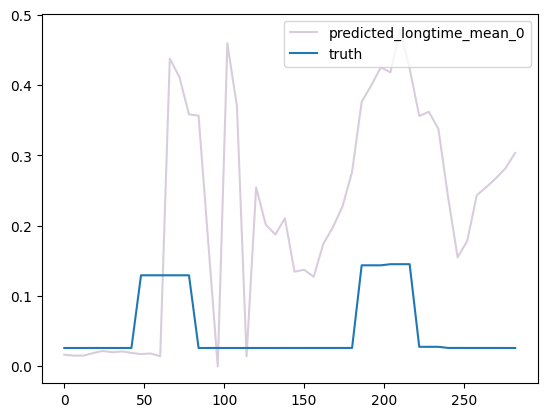

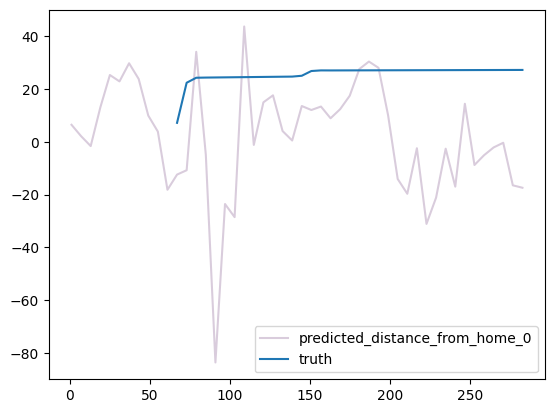

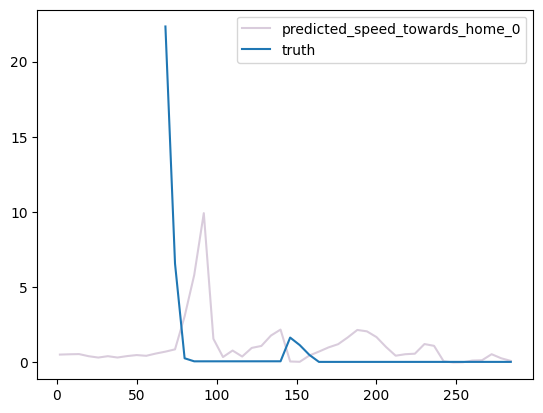

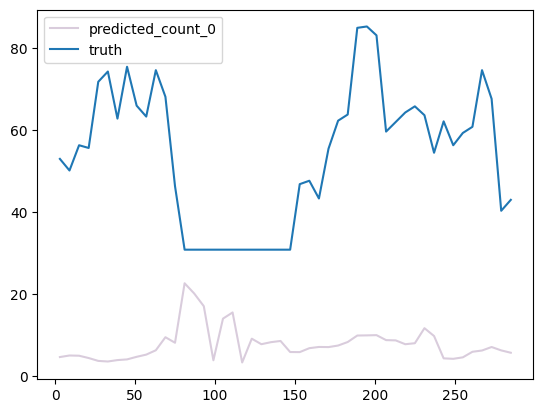

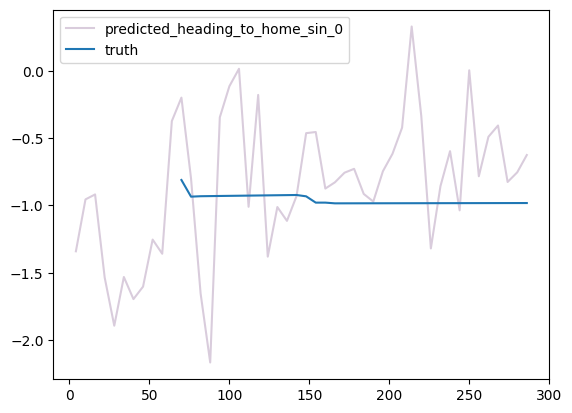

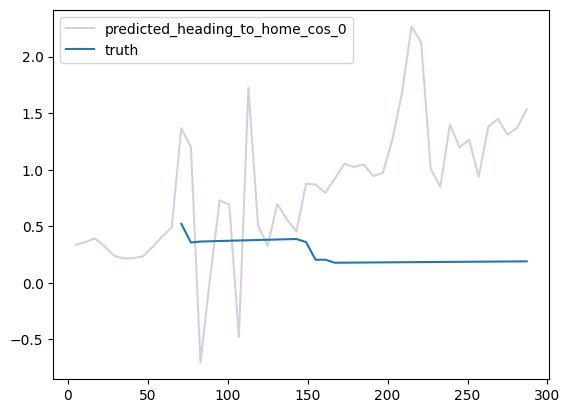

In [ ]:
for predicted_column in predicted_columns:
    number_of_steps = 1
    #create a list of collors from 0 to 12 based on color
    colors = plt.cm.viridis(np.linspace(0, 1, number_of_steps))
    for i in range(0, number_of_steps):
        plt.plot(result_df.loc[result_df['prediction']==predicted_column,i][:48], label=f'predicted_{predicted_column}_{i}', color=colors[i], alpha=0.2)
    # i =0
    # plt.plot(df_shift[i], label=f'{i}_step_ahead')
    plt.plot(result_df.loc[result_df['prediction'] == predicted_column,'truth'][:48], label='truth')
    plt.legend()   
    plt.show()

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

### Get R2 for this prediction

In [ ]:
print(y_truth.shape)

(1528, 6)


In [ ]:
print(y_pred.shape)

(1528, 6)


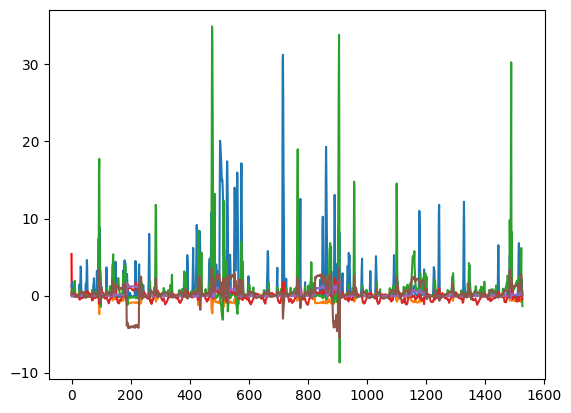

In [ ]:
#plot y_truth and y_pred
plt.plot(y_truth[0], color = 'red', label = 'Real data')

plt.plot(y_pred)


[   0   24   48   72   96  120  144  168  192  216  240  264  288  312
  336  360  384  408  432  456  480  504  528  552  576  600  624  648
  672  696  720  744  768  792  816  840  864  888  912  936  960  984
 1008 1032 1056 1080 1104 1128 1152 1176 1200 1224 1248 1272 1296 1320
 1344 1368 1392 1416 1440 1464 1488 1512 1536]


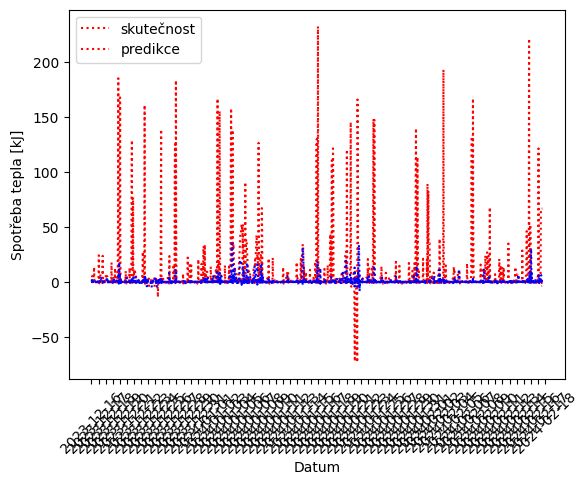

In [ ]:

plt.plot(y_truth, color = 'red', linestyle='dotted')
plt.plot(y_pred, color = 'blue', linestyle='dotted')
# change x ticks to dates
print(np.arange(0, df_test.shape[0], step=24))
# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')
end = start + pd.Timedelta(hours=df_test.shape[0])
dates = pd.date_range(start, end, freq='1H')

# transform dates to format MM-DD HH
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, df_test.shape[0], step=24), dates[np.arange(0, df_test.shape[0], step=24)], rotation=45)

#add legend
plt.legend(['skutečnost','predikce'])

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')


plt.show()

## Let's try the evaluate_generator in keras

In [ ]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)


/var/folders/8t/gl5rl9r94nl0wvx62zrp3pcr0000gn/T/ipykernel_35651/2211671762.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  (_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)


TypeError: cannot unpack non-iterable float object